In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import sklearn 
from sklearn.model_selection import train_test_split
import datetime

In [102]:
df1 = pd.read_csv("~/Workspace/Cars/acvdata/dta1.csv") 
df2 = pd.read_csv("~/Workspace/Cars/acvdata/dta2.csv") 

In [103]:
#df1.head(10)
#df1.info() #3756 rows
df2.info() #2353 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user                  2353 non-null   object
 1   joined_timestamp      2353 non-null   object
 2   num_auctions_engaged  2353 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 55.3+ KB


## Get userid from timestamp

In [104]:
df1.groupby('joined_timestamp').joined_timestamp.nunique().count() #3754 < 3756 ?? Probably just signed up at the exact time.
# Even if they didn't sign up at the same time, one user is not enough for me to work on.
df1.joined_timestamp.value_counts() 
#df2.groupby('joined_timestamp').joined_timestamp.nunique().count() # These are all unique users

2017-09-08 04:37:49    2
2017-10-17 09:45:36    2
2017-09-09 01:52:10    1
2017-12-20 04:06:25    1
2017-10-11 05:25:09    1
                      ..
2016-07-13 05:21:04    1
2016-05-14 02:29:29    1
2017-02-15 02:41:41    1
2017-12-01 02:17:53    1
2017-09-06 04:55:38    1
Name: joined_timestamp, Length: 3754, dtype: int64

In [105]:
df1.groupby('user').count() # Buyer: 2776, Seller: 980
df1.user.value_counts(normalize=1) # Buyer: 73.91%, Seller: 26.09%
df2.groupby('user').count() # Buyer 1594, Seller: 759
df2.user.value_counts(normalize=1) # Buyer: 67.74%, Seller: 32.26%

buyer     0.677433
seller    0.322567
Name: user, dtype: float64

In [106]:
def date_convert(date_to_convert):
     return datetime.datetime.strptime(date_to_convert, '%Y-%m-%d %H:%M:%S')

df1['ts'] = df1['joined_timestamp'].apply(date_convert)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3756 entries, 0 to 3755
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user                  3756 non-null   object        
 1   joined_timestamp      3756 non-null   object        
 2   num_auctions_engaged  3756 non-null   int64         
 3   ts                    3756 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 117.5+ KB


In [107]:
def date_convert(date_to_convert):
     return datetime.datetime.strptime(date_to_convert, '%Y-%m-%d %H:%M:%S')

df2['ts'] = df2['joined_timestamp'].apply(date_convert)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user                  2353 non-null   object        
 1   joined_timestamp      2353 non-null   object        
 2   num_auctions_engaged  2353 non-null   int64         
 3   ts                    2353 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 73.7+ KB


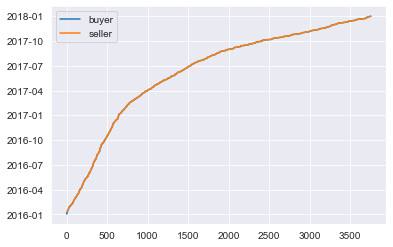

In [108]:
#Users over time - Users have increased
df1.groupby('user')['ts'].plot(legend='True')
plt.show()

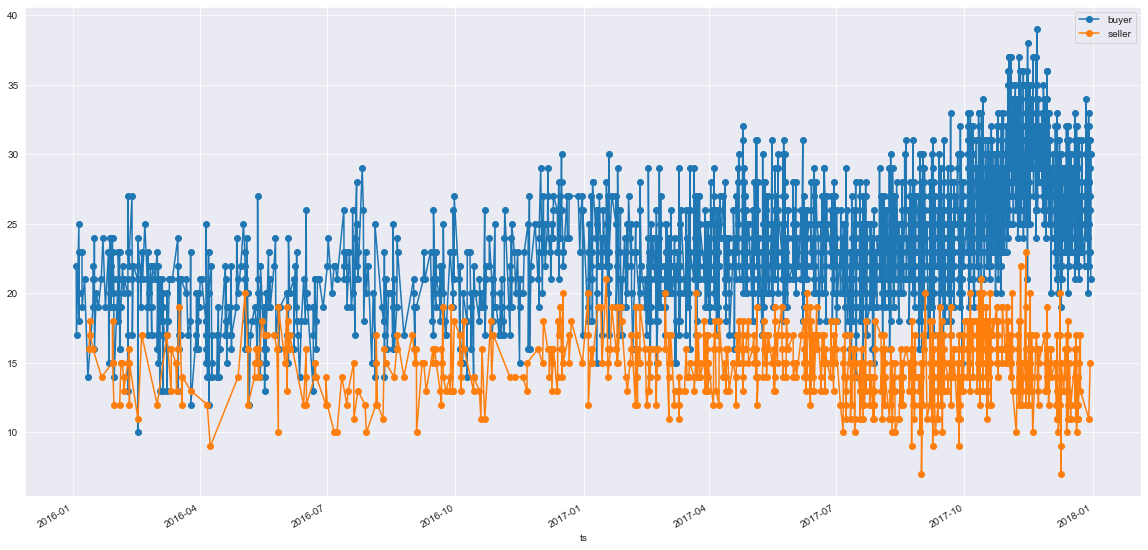

In [109]:
# There is more engagment from buyers coming onto the app!!
def plot_gb_time_series(df1, ts, user, num_auctions_engaged, figsize=(20,7), title=None):

    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df1.groupby(['user']):
        ax = grp.plot(ax=ax, kind='line', x=ts, y=num_auctions_engaged, label=key, marker='o')
    plt.show()
    
plot_gb_time_series(df1, 'ts', 'user', 'num_auctions_engaged',
                    figsize=(20, 10))

### Let's add more features ###

In [110]:
# Extract the year, month, day - The first thing that came to mind
df1['Year'] = pd.DatetimeIndex(df1['ts']).year
df1['Month'] = pd.DatetimeIndex(df1['ts']).month
df1['Day'] = pd.DatetimeIndex(df1['ts']).day
df1['Hour'] = pd.DatetimeIndex(df1['ts']).hour
df1['Minute'] = pd.DatetimeIndex(df1['ts']).minute
df1['Second'] = pd.DatetimeIndex(df1['ts']).second
df1.head(2)

,user,joined_timestamp,num_auctions_engaged,ts,Year,Month,Day,Hour,Minute,Second
0,buyer,2016-01-03 02:20:27,22,2016-01-03 02:20:27,2016,1,3,2,20,27
1,buyer,2016-01-03 07:57:13,17,2016-01-03 07:57:13,2016,1,3,7,57,13


## I could look at adding the day before (As a column), don't think I have enough time.
### Like a Lag Window Function

# Visualize some date formats #

10    571
12    503
9     449
11    435
8     332
7     261
5     260
6     226
3     217
4     197
2     170
1     135
Name: Month, dtype: int64

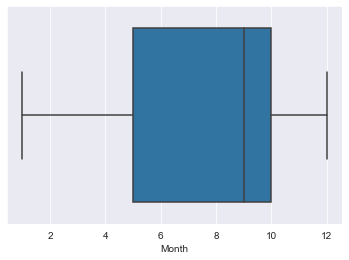

In [111]:
sns.boxplot(x='Month', data=df1)
df1.Month.value_counts(normalize=0)
# The Fall/Winter seems to have a lot going for it - Maybe Group by seasons for your model.

In [113]:
# df1.Year.value_counts(normalize=0) - 2016 & 2017
# When did the year start (What month)
df1['year_month'] = pd.to_datetime(df1['ts']).dt.to_period('M')
df1.head(2)

,user,joined_timestamp,num_auctions_engaged,ts,Year,Month,Day,Hour,Minute,Second,year_month
0,buyer,2016-01-03 02:20:27,22,2016-01-03 02:20:27,2016,1,3,2,20,27,2016-01
1,buyer,2016-01-03 07:57:13,17,2016-01-03 07:57:13,2016,1,3,7,57,13,2016-01


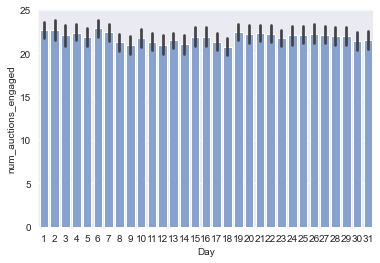

In [126]:
sns.barplot(x = df1['Day'], y = df1['num_auctions_engaged'], color = '#7B9FDA')

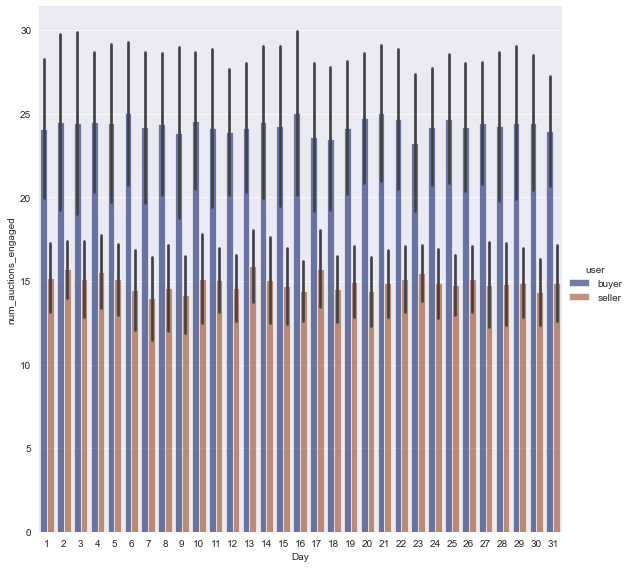

In [138]:
# ehh
sns.catplot(
    data=df1, kind="bar",
    x="Day", y="num_auctions_engaged", hue="user",
    ci="sd", palette="dark", alpha=.6, height=8
)

In [116]:
#sns.boxplot(x='year_month', data=df1) - didn't work (Have to convert to string)
df1.year_month.value_counts(normalize=0) # - My above theory still holds up, fall and winter are good indicators

2017-10    515
2017-12    436
2017-09    387
2017-11    387
2017-08    291
2017-07    215
2017-05    196
2017-06    177
2017-03    153
2017-04    152
2017-02    110
2017-01     91
2016-12     67
2016-05     64
2016-03     64
2016-09     62
2016-02     60
2016-10     56
2016-06     49
2016-11     48
2016-07     46
2016-04     45
2016-01     44
2016-08     41
Freq: M, Name: year_month, dtype: int64

## Start of a test ##

In [117]:
X = df1[['ts', 'user', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'year_month']]
y = df1['num_auctions_engaged']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [119]:
cars_train = pd.concat([X_train, y_train], axis = 1)
cars_train

,ts,user,Year,Month,Day,Hour,Minute,Second,year_month,num_auctions_engaged
1489,2017-06-24 08:54:09,seller,2017,6,24,8,54,9,2017-06,15
1112,2017-04-22 06:57:25,buyer,2017,4,22,6,57,25,2017-04,22
1212,2017-05-10 04:52:49,seller,2017,5,10,4,52,49,2017-05,16
2546,2017-10-09 07:03:41,buyer,2017,10,9,7,3,41,2017-10,31
223,2016-05-05 02:23:11,seller,2016,5,5,2,23,11,2016-05,16
...,...,...,...,...,...,...,...,...,...,...
3039,2017-11-08 06:54:56,buyer,2017,11,8,6,54,56,2017-11,26
3464,2017-12-09 05:31:36,seller,2017,12,9,5,31,36,2017-12,15
427,2016-09-08 23:55:16,buyer,2016,9,8,23,55,16,2016-09,21
705,2017-01-19 05:31:06,buyer,2017,1,19,5,31,6,2017-01,22


In [120]:
cars_test = pd.concat([X_test,y_test], axis = 1)
cars_test

,ts,user,Year,Month,Day,Hour,Minute,Second,year_month,num_auctions_engaged
2391,2017-09-29 01:22:31,seller,2017,9,29,1,22,31,2017-09,14
2713,2017-10-18 04:58:14,buyer,2017,10,18,4,58,14,2017-10,31
2043,2017-09-01 06:29:02,buyer,2017,9,1,6,29,2,2017-09,27
551,2016-11-12 05:25:18,buyer,2016,11,12,5,25,18,2016-11,23
1819,2017-08-10 07:04:29,buyer,2017,8,10,7,4,29,2017-08,22
...,...,...,...,...,...,...,...,...,...,...
1938,2017-08-25 03:00:19,seller,2017,8,25,3,0,19,2017-08,15
3541,2017-12-14 07:22:15,seller,2017,12,14,7,22,15,2017-12,13
461,2016-09-24 05:00:31,buyer,2016,9,24,5,0,31,2016-09,17
594,2016-12-07 12:27:44,buyer,2016,12,7,12,27,44,2016-12,23


## Now that we split our test and train data, lets pick a model:

In [122]:
linear_model = smf.ols(formula='num_auctions_engaged ~ C(Year) + C(Month) + C(Hour) + C(Minute) + C(user)', data=cars_train).fit()

linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     num_auctions_engaged   R-squared:                       0.705
Model:                              OLS   Adj. R-squared:                  0.696
Method:                   Least Squares   F-statistic:                     73.23
Date:                  Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                          17:48:11   Log-Likelihood:                -7631.6
No. Observations:                  3004   AIC:                         1.546e+04
Df Residuals:                      2908   BIC:                         1.603e+04
Df Model:                            95                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            20.5445      0.577     35.627      0.000      19.414      21.675
C(Year)[T.2017]       2.9892      0.155     19.288      0.000       2.685       3.293
C(Month)[T.2]        -1.0430      0.403     -2.588      0.010      -1.833      -0.253
C(Month)[T.3]        -1.2860      0.388     -3.313      0.001      -2.047      -0.525
C(Month)[T.4]        -0.8485      0.397     -2.139      0.033      -1.626      -0.071
C(Month)[T.5]         0.0561      0.378      0.149      0.882      -0.684       0.797
C(Month)[T.6]        -0.1560      0.384     -0.406      0.685      -0.909       0.597
C(Month)[T.7]        -1.1961      0.375     -3.191      0.001      -1.931      -0.461
C(Month)[T.8]        -0.6710      0.363     -1.849      0.064      -1.382       0.040
C(Month)[T.9]        -0.1323      0.349     -0.379      0.705      -0.817       0.552
C(Month)[T.10]        2.2887      0.341      6.715      0.000       1.620       2.957
C(Month)[T.11]        4.6037      0.351     13.121      0.000       3.916       5.292
C(Month)[T.12]        2.2462      0.344      6.531      0.000       1.572       2.921
C(Hour)[T.1]         -0.1946      0.267     -0.728      0.467      -0.719       0.329
C(Hour)[T.2]         -0.1205      0.264     -0.457      0.648      -0.638       0.397
C(Hour)[T.3]          0.2937      0.272      1.079      0.281      -0.240       0.827
C(Hour)[T.4]         -0.2528      0.265     -0.953      0.341      -0.773       0.268
C(Hour)[T.5]         -0.1945      0.266     -0.732      0.464      -0.715       0.326
C(Hour)[T.6]          0.0290      0.280      0.104      0.917      -0.519       0.577
C(Hour)[T.7]          0.0302      0.311      0.097      0.923      -0.579       0.640
C(Hour)[T.8]         -0.2861      0.404     -0.708      0.479      -1.078       0.506
C(Hour)[T.9]         -0.2516      0.451     -0.558      0.577      -1.136       0.633
C(Hour)[T.10]        -0.6201      0.499     -1.242      0.214      -1.599       0.359
C(Hour)[T.11]        -0.0084      0.477     -0.018      0.986      -0.943       0.926
C(Hour)[T.12]        -0.0312      0.547     -0.057      0.955      -1.104       1.042
C(Hour)[T.13]         0.6436      0.615      1.047      0.295      -0.562       1.849
C(Hour)[T.14]         0.3317      0.795      0.417      0.676      -1.226       1.890
C(Hour)[T.15]         1.3085      1.072      1.221      0.222      -0.793       3.410
C(Hour)[T.16]        -2.1313      1.835     -1.161      0.246      -5.730       1.467
C(Hour)[T.17]         2.5543      1.592      1.604      0.109      -0.568       5.677
C(Hour)[T.18]        -0.5664      1.428     -0.396      0.692      -3.367       2.235
C(Hour)[T.19]        -3.9350      1.837     -2.142      0.032      -7.537      -0.333
C(Hour)[T.20]         0.7978      0.870      0.917 

In [123]:
from sklearn.metrics import r2_score
linear_model.params

Intercept            20.544504
C(Year)[T.2017]       2.989217
C(Month)[T.2]        -1.042986
C(Month)[T.3]        -1.286049
C(Month)[T.4]        -0.848531
                       ...    
C(Minute)[T.56]       0.657416
C(Minute)[T.57]       0.227271
C(Minute)[T.58]       0.515871
C(Minute)[T.59]      -0.042302
C(user)[T.seller]    -9.232143
Length: 96, dtype: float64

In [125]:
y_test_pred = linear_model.predict(X_test)
r2_score(y_test, y_test_pred)

0.6870837761212965

# The model did ok, given the features it had

## My thoughts:
1) This was challenging for me. I have not had a chance to do modeling other than linear and logistic regression, aside from this I have never worked with only 3 columns (That was challenging for me/ I was intimidated)

2) I could have taken the route of making a logistic regression model to predict wether the user would be a buyer or seller

3) Another feature I could have added is the day before - Both points 1 & 2 are just a question of time.

## Describe what you can of the marketplace this data represents
I can see from the data that the market is bullish/getting better.
The growth of users is clear, and there tends to be more buyer than sellers? Why is that? Maybe the deals are so good for the buyers and not the sellers, maybe it is difficult for the sellers to believe in the product or make good profit.
I also see that the later months have more enaggement - first thing that pops to mind is that no one wants to be outside in the winter so that makes sense - take this to the scandinavian countries!!!

## Explain why/if one model is better than the other
There was only one model, I want to join this team so I can do just that, learn a lot more about modeling.

## Explain your choices for evaluation
This is the way I was taught to evaluate the model.

# THANK YOU! #